In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The data file does not contain column names, so we add them as a parameter to the csv reader.

In [ ]:
columns_names = ['BI-RADS','Age','Shape','Margin','Density','Severity']
df_mamma = pd.read_csv('/content/drive/My Drive/IAAE/data/mamma.data.txt',names=columns_names)

In [ ]:
df_mamma.shape

(961, 6)

In [ ]:
df_mamma.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


## Convert data types

In [ ]:
df_mamma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   BI-RADS   961 non-null    object
 1   Age       961 non-null    object
 2   Shape     961 non-null    object
 3   Margin    961 non-null    object
 4   Density   961 non-null    object
 5   Severity  961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


Looking at the [description of the dataset](https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass) we learn that `BI-RADS assesment` and `Density` are **ordered variables**. Let's take a look.

(Note at the description that the first of the variables is a non-predictive variable that won't be used if we build a predictive model)

In [ ]:
df_mamma['BI-RADS'].value_counts()

4     547
5     345
3      36
2      14
6      11
0       5
?       2
55      1
Name: BI-RADS, dtype: int64

In [ ]:
df_mamma['Density'].value_counts()

3    798
?     76
2     59
1     16
4     12
Name: Density, dtype: int64

Numbers have been interpreted as nominal values. We will convert the columns to float.

According to the description, values for `BI-RADS` range from 1 to 5, and there are some rows containing 0's and a 55. We will deal with it later.

We also notice that some values are question marks. This is a way of coding missing values. We first will code these values as NaN, one of the representations in Pandas for missing values and we will deal with the problem later.



In [ ]:
df_mamma = df_mamma.replace('?',np.nan)

In [ ]:
df_mamma['BI-RADS'] = df_mamma['BI-RADS'].astype('float64')
df_mamma['Density'] = df_mamma['Density'].astype('float64')

`Age` should also be numeric

In [ ]:
df_mamma['Age'] = df_mamma['Age'].astype('float64')

## Encoding categorical variables

`Shape` and `Margin` are described in the documentation as nominal. Since sklearn requires all predictors to be numeric, we will encode them as dummy variables.

For each different nominal value, a new binary column will be created indicating wether the nominal value was present or not.

In [ ]:
df_mamma = pd.get_dummies(df_mamma, columns=['Shape','Margin'])

In [ ]:
df_mamma.head()

,BI-RADS,Age,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5
0,5.0,67.0,3.0,1,0,0,1,0,0,0,0,0,1
1,4.0,43.0,NaN,1,1,0,0,0,1,0,0,0,0
2,5.0,58.0,3.0,1,0,0,0,1,0,0,0,0,1
3,4.0,28.0,3.0,0,1,0,0,0,1,0,0,0,0
4,5.0,74.0,NaN,1,1,0,0,0,0,0,0,0,1


Let's check out again data types

In [ ]:
df_mamma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   Age       956 non-null    float64
 2   Density   885 non-null    float64
 3   Severity  961 non-null    int64  
 4   Shape_1   961 non-null    uint8  
 5   Shape_2   961 non-null    uint8  
 6   Shape_3   961 non-null    uint8  
 7   Shape_4   961 non-null    uint8  
 8   Margin_1  961 non-null    uint8  
 9   Margin_2  961 non-null    uint8  
 10  Margin_3  961 non-null    uint8  
 11  Margin_4  961 non-null    uint8  
 12  Margin_5  961 non-null    uint8  
dtypes: float64(3), int64(1), uint8(9)
memory usage: 38.6 KB


Now that every column is numeric, we can take a look at the descriptive statistics and boxplot.

## Out of domain values/Outliers

In [ ]:
df_mamma.describe()

,BI-RADS,Age,Density,Severity,Shape_1,Shape_2,Shape_3,Shape_4,Margin_1,Margin_2,Margin_3,Margin_4,Margin_5
count,959.000000,956.000000,885.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,4.348279,55.487448,2.910734,0.463059,0.233091,0.219563,0.098855,0.416233,0.371488,0.024974,0.120708,0.291363,0.141519
std,1.783031,14.480131,0.380444,0.498893,0.423020,0.414166,0.298623,0.493190,0.483454,0.156127,0.325957,0.454627,0.348738
min,0.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,45.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,57.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,66.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,55.000000,96.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


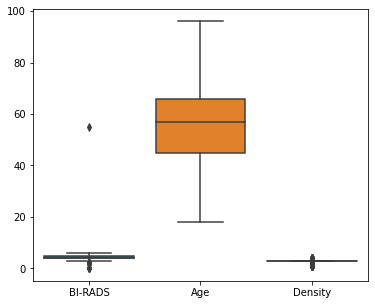

In [ ]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df_mamma[['BI-RADS','Age','Density']])

We have already noticed some wrong values in the `BI-RADS` variable because we now its domain. But even without that information, both the max value in the table above and the point in the boxplot suggest an outlier.

We will remove the rows with out of domain values.

In [ ]:
df_mamma = df_mamma.drop(df_mamma[(df_mamma['BI-RADS']>6) | (df_mamma['BI-RADS']<1)].index)

We extract from the data the X matrix with the predictive variables and the y vector for the class labels.

In [ ]:
X = df_mamma.drop('Severity',axis=1)

In [ ]:
y = df_mamma['Severity']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=10,stratify=y)

## Missing values



1. Drop rows with missing values
2. Impute missing values
    * Replace missing values with mean or median
    * Use an ML to predict missing values (e.g. kNN)





In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 602 to 301
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   668 non-null    float64
 1   Age       665 non-null    float64
 2   Density   612 non-null    float64
 3   Shape_1   668 non-null    uint8  
 4   Shape_2   668 non-null    uint8  
 5   Shape_3   668 non-null    uint8  
 6   Shape_4   668 non-null    uint8  
 7   Margin_1  668 non-null    uint8  
 8   Margin_2  668 non-null    uint8  
 9   Margin_3  668 non-null    uint8  
 10  Margin_4  668 non-null    uint8  
 11  Margin_5  668 non-null    uint8  
dtypes: float64(3), uint8(9)
memory usage: 26.7 KB


In [ ]:
imputer = KNNImputer(n_neighbors=1)

In [ ]:
imputer.fit(X_train)

KNNImputer(n_neighbors=1)

In [ ]:
X_train[:] = imputer.transform(X_train)

In [ ]:
X_test[:] = imputer.transform(X_test)

## Scaling

In [ ]:
std_scaler = StandardScaler()

In [ ]:
std_scaler.fit(X_train)

StandardScaler()

In [ ]:
X_train_arr = std_scaler.transform(X_train)

In [ ]:
X_train_sc = pd.DataFrame(X_train_arr,columns=X_train.columns,index=X_train.index)

In [ ]:
X_test_arr = std_scaler.transform(X_test)

In [ ]:
X_test_sc = pd.DataFrame(X_test_arr,columns=X_test.columns,index=X_test.index)